In [1]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd())) 

from utils.generate_model import init_state, load_trained_ckpt
from utils.transforms import (
    Compose, ToTensor, MultiScaleRandomCrop, MultiScaleCornerCrop, Normalize,
    TemporalRandomCrop, TemporalCenterCrop, LoopPadding)
from utils.target_columns import get_target_columns
from utils.mean import get_mean, get_std
from utils.preprocessing import (
    PatientLocalizer,
    COPAnalyizer,
    HumanScaleAnalyizer,
    Worker,
)
import datasets.gaitregression
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import sklearn
import visdom
import torch.nn.functional as F
import torchvision.transforms as TF
import json
from types import SimpleNamespace
import re
import cv2
from PIL import Image
import copy
from torch.utils.data import Dataset, DataLoader
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import collections
from dateutil.parser import parse
import datetime
from IPython.core.debugger import set_trace

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="8"

In [3]:
df = pd.read_excel('../data/NPH_data.xlsx')

In [4]:
# add CV columns
old_columns = [('Stride Length Std Dev', 'Stride Length(cm)'),
               ('Stride Time Std Dev', 'Cycle Time(sec)')]

new_columns = ['CV Stride Length', 'CV Stride Time']

for new_col, old_cols in zip(new_columns, old_columns):
    for tail in ['(LEFT)', '(RIGHT)']:
        df[new_col + tail] = 100 * df[old_cols[0] + tail] / df[old_cols[1]+tail]

# Match time format

In [5]:
def match_timeformat(x):
    if type(x) == datetime.datetime:
        return x.strftime("%Y-%m-%d")
        #return datetime.datetime(x.year, x.month, x.day)
    p = re.match(r'(?P<year>\d\d\d)-(?P<month>\d\d)-(?P<day>\d\d)', x)
    group_map = p.groupdict()
    date_groups = [ group_map['month'], group_map['day'], group_map['year']]

    for i in range(len(date_groups)):
        date_groups[i] = str(int(date_groups[i]))
    
    dt = parse('/'.join(date_groups))
    return dt.strftime("%Y-%m-%d")

df["DATE"] = df["DATE"].map(match_timeformat)

# Add a group column to distinguish evaluation groups

In [ ]:
df_list = []
for pat_id in df["PAT ID"].unique():
    patient_df = df[df["PAT ID"] == int(pat_id) ]
    #print(f"Min : {patient_df['DATE'].min()} \t Max : {patient_df['DATE'].max()}")    
    baseline_group = patient_df[patient_df.DATE==patient_df['DATE'].min()].copy()
    baseline_group.loc[:,'GROUP'] = 'baseline'
    followup_group = patient_df[patient_df.DATE==patient_df['DATE'].max()].copy()
    followup_group.loc[:,'GROUP'] = 'followup'
    df_list.append(pd.concat([baseline_group, followup_group], axis=0))
    
df = pd.concat(df_list, axis=0).reset_index(drop=True)

In [6]:
# load config file for demo
opt = SimpleNamespace(**json.load(open('../data/demo_config.json')))

# attention indicator
opt.attention_str = 'Attentive' if opt.attention else 'NonAttentive'
opt.group_str = f"G{opt.n_groups}" if opt.n_groups > 0 else ''
opt.arch = "{}-{}".format(opt.backbone, opt.model_depth)

target_columns = get_target_columns(opt)

opt.mean = get_mean(opt.norm_value, dataset=opt.mean_dataset)
opt.std = get_std(opt.norm_value, dataset=opt.mean_dataset)

if opt.no_mean_norm and not opt.std_norm:
    norm_method = Normalize([0, 0, 0], [1, 1, 1])
else:
    norm_method = Normalize(opt.mean, opt.std)

if opt.train_crop == "random":
    crop_method = MultiScaleRandomCrop(opt.scales, opt.sample_size)
elif opt.train_crop == "corner":
    crop_method = MultiScaleCornerCrop(opt.scales, opt.sample_size)
elif opt.train_crop == "center":
    crop_method = MultiScaleCornerCrop(
        opt.scales, opt.sample_size, crop_positions=["c"]
    )

spatial_transform = {
    "train": Compose(
        [
            TF.RandomRotation(degrees=(0, 0)),
            TF.RandomResizedCrop(size=opt.sample_size,
                                 scale=(opt.sample_size/opt.img_size, 1.0)),
            ToTensor(opt.norm_value),
            norm_method,
        ]
    ),
    "test": Compose(
        [
            TF.CenterCrop(opt.sample_size),
            ToTensor(opt.norm_value),
            norm_method,
        ]
    ),
}

temporal_transform = {
    "train": None,  # TemporalRandomCrop(opt.sample_duration),
    "test": None,  # TemporalCenterCrop(opt.sample_duration),
}

from sklearn.preprocessing import StandardScaler
target_transform = StandardScaler()

# prepare dataset
_ = datasets.gaitregression.prepare_dataset(
    input_file=opt.detection_file,
    target_file=opt.target_file,
    target_columns=target_columns,
    chunk_parts=opt.chunk_parts,
    target_transform=target_transform,
)

# format target columns
for old, new in zip(['/L','/R'], ['(LEFT)', '(RIGHT)']):
    target_columns = np.char.replace(target_columns, old, new)
target_columns = target_columns.tolist()

In [ ]:
opt.benchmark = False

# define regression model
net, criterion1, criterion2, optimizer, scheduler = init_state(opt)
net = load_trained_ckpt(opt, net)

In [ ]:
def predict(net, dl, target_transform):
    res = []
    for input_data in tqdm(dl):
        out = net(input_data)
        reg_outputs = out[0]
        reg_outputs = target_transform.inverse_transform(
            reg_outputs.detach().cpu().numpy())
        res.append(reg_outputs)
    
    return np.vstack(res)

In [ ]:
import json
exception_dict = json.load(open('../data/group_exceptions.json'))

exception_dict = {"baseline": df[df["Serial Num"].isin(exception_dict['baseline'])].FILENAME,
              "followup": df[df["Serial Num"].isin(exception_dict['followup'])].FILENAME}          

In [ ]:
# excluede samples without any video file
patient_list = list(set(df.FILENAME.values)-{"7181794_basic_test_2_trial_3.txt", 
                                             "7005361_basic_test_4_trial_1.txt", 
                                             "7005361_basic_test_4_trial_0.txt",
                                             "1909243_basic_test_2_trial_0.txt",
                                             "1909243_basic_test_2_trial_1.txt",
                                             "1909243_basic_test_2_trial_2.txt",
                                             "1909243_basic_test_2_trial_3.txt",
                                             "1194117_basic_test_1_trial_0.txt",
                                             "1194117_basic_test_1_trial_1.txt",
                                             "1194117_basic_test_1_trial_2.txt",
                                             "1194117_basic_test_1_trial_3.txt",
                                             "1019153_basic_test_3_trial_0.txt",
                                             "1019153_basic_test_3_trial_1.txt",
                                             "1019153_basic_test_3_trial_2.txt",
                                             "1019153_basic_test_3_trial_3.txt"})

In [ ]:
def match_NameFormat(x):
    x = os.path.splitext(x)[0]
    regex = re.compile(r'(.*)_basic_test_(.*)_trial_(.*)')
    pid, test_ix, trial_ix = regex.search(x).groups()
    return f'{pid}_test_{test_ix}_trial_{trial_ix}' + '.avi'

class NPH_Dataset(Dataset):
    def __init__(self, opt, data,
                 interval_selector, target_columns, spatial_transform):
        self.opt = opt
    
        column_sel = ["Serial Num", "PAT ID", "DATE", "TIME", "FILENAME", *target_columns]
        data = data[column_sel] # only use selected colums
        
        self.input_files = [ os.path.join(opt.data_root,x) for x in data.FILENAME.map(match_NameFormat).values ]
        self.interval_selector = interval_selector
        self.spatial_transform = spatial_transform
        
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, idx):
        video = self.input_files[idx]
        vid = os.path.splitext(os.path.basename(video))[0]
        
        start_ix, end_ix = self.interval_selector.get_interval(
            vid=vid, return_index=True)
        
        if not os.path.exists(video):
            print(video)
        
        cap = cv2.VideoCapture(video)

        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            # cvt color map (bgr->rgb)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(frame).resize(
                (self.opt.img_size, self.opt.img_size))
            img_tensor = self.spatial_transform(img)
            frames.append(img_tensor)

        # time intervals of interest
        frames = frames[start_ix:end_ix+1]

        frame_indices = torch.LongTensor(
            np.linspace(
                0, len(frames), self.opt.sample_duration, endpoint=False).astype(np.int)
        )
        input_data = torch.stack(frames)[frame_indices].permute(1, 0, 2, 3)

        padding = (0, 0,
                   0, 0,
                   0, self.opt.sample_duration - len(frame_indices))

        # zero padding
        input_data = F.pad(input_data, padding)
        return input_data

In [ ]:
from IPython.core.debugger import set_trace

def check_file(x, *args, **kwargs):
    video = match_NameFormat(x)
    vpath = os.path.join(kwargs['opt'].video_home, video)
    return os.path.exists(vpath)

def get_prediction_result(net, opt, df, interval_selector, condition,
                          target_columns, spatial_transform, target_transform):
    
    df = copy.copy(df)
    
    # get df of given condition (baseline | followup)
    df = df[df.GROUP==condition]
    patient_list = list(set(df.FILENAME)-set(exception_dict[condition]))
    
    pat_s = pd.Series(patient_list)
    patient_list = pat_s[pat_s.apply(check_file, opt=opt)].values
    
    # takes only use existing files
    df = df[df.FILENAME.isin(patient_list)]

    df['Type'] = np.tile('gt', len(df))
    column_sel = ["Serial Num", "PAT ID", "DATE", "TIME", "FILENAME", *target_columns, "Type", "GROUP"]
    
    df = df[column_sel].applymap(lambda x: np.nan if x=='<missing>' else x)

    nan_patients = []
    for i,x in enumerate((df.isna()).any(axis=1)):
        if x:
            nan_patients.append(df.iloc[i]["FILENAME"])

    # remove missing rows
    df = df.dropna()

    N_samples = len(df)
    N_factors = len(target_columns)

    print(f'[Evaluation for \'{condition}\' group] ### total data samples (n) : {N_samples}, found {len(nan_patients)} missing row(s)...')
    
    input_data = df.values
            
    # init dataset
    ds = NPH_Dataset(opt, df, interval_selector, target_columns, spatial_transform=spatial_transform)
    dl = DataLoader(ds, batch_size=opt.batch_size, shuffle=False, num_workers=8)
    
    # result from AGNet
    with torch.no_grad():
        net.eval()
        res = predict(net, dl, target_transform=target_transform)
        
    res = np.column_stack((df.loc[:,:"FILENAME"].values, res, 
                           np.tile('pred', N_samples), np.tile(condition, N_samples)))
    data = np.row_stack((input_data, res))

    return pd.DataFrame(data,columns=["Serial Num", "PAT ID", "DATE", "TIME", "FILENAME", *target_columns, "Type", "GROUP"])

res = {}

for condition in ['baseline', 'followup']:
    res[condition] = get_prediction_result(net, 
                                           opt, 
                                           df, 
                                           interval_selector = COPAnalyizer(opt.meta_home, opt.fps),
                                           condition=condition,
                                           target_columns=target_columns,
                                           spatial_transform=spatial_transform['test'],
                                           target_transform=target_transform)

In [ ]:
def scatterplots(target_columns, y_true, y_pred, scores, condition):
    pred_and_gt = {k: [] for k in target_columns}

    for i, col in enumerate(target_columns):
        pred_and_gt[col].append([y_pred[:, i], y_true[:, i]])

    data = collections.defaultdict(list)

    pp = []
    gg = []
    for i, col in enumerate(pred_and_gt.keys()):
        transposed_data = list(zip(*pred_and_gt[col]))
        preds = np.concatenate(transposed_data[0])
        gts = np.concatenate(transposed_data[1])

        pp.append(preds)
        gg.append(gts)

        for p, g in zip(preds, gts):
            data["name"].append(col)
            data["pred"].append(p)
            data["gt"].append(g)

    df = pd.DataFrame(data)

    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
    fig.suptitle(fr'$ScatterPlots$ ({condition})', fontsize=30, y=0.98)

    axes = axes.flatten()

    for i, (preds, gts) in enumerate(zip(pp, gg)):
        ax = axes[i]
        preds = np.array(preds)
        gts = np.array(gts)

        ax.set_xlim(min(gts), max(gts))
        ax.set_ylim(min(preds), max(preds))
        
        ax.scatter(gts, preds, c='g', label='data')
        ax.plot([min(gts), max(gts)], [min(gts), max(gts)],
                'r--', label='GT-line')
        ax.set_xlabel('GT', fontsize=15)
        ax.set_ylabel('PRED', fontsize=15)
        
        ax.set_title(f'name={target_columns[i]}\n' + r'[$r^2 = {:0.3f}$]'.format(scores[i]), fontdict={'fontsize': 15})
        ax.legend(loc='lower right')

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.4, top=0.9)

    
    
def BlandAltmanplots(target_columns, y_true, y_pred, condition):
    pred_and_gt = {k: [] for k in target_columns}

    for i, col in enumerate(target_columns):
        pred_and_gt[col].append([y_pred[:, i], y_true[:, i]])

    data = collections.defaultdict(list)

    pp = []
    gg = []
    for i, col in enumerate(pred_and_gt.keys()):
        transposed_data = list(zip(*pred_and_gt[col]))
        preds = np.concatenate(transposed_data[0])
        gts = np.concatenate(transposed_data[1])

        pp.append(preds)
        gg.append(gts)

        for p, g in zip(preds, gts):
            data["name"].append(col)
            data["pred"].append(p)
            data["gt"].append(g)

    df = pd.DataFrame(data)
    
    fig = plt.figure(figsize=(20,20))
    fig.suptitle(fr'$BlandAltmanPlots$ ({condition})', fontsize=30, y=0.98)

    for i, (preds, gts) in enumerate(zip(pp, gg)):
        ax = fig.add_subplot(5,4,i+1)
        preds = np.array(preds)
        gts = np.array(gts)
        sm.graphics.mean_diff_plot(preds, gts, ax = ax)
        ax.set_title(f'name={target_columns[i]}\n' + r'[$r^2 = {:0.3f}$]'.format(scores[i]), fontdict={'fontsize': 15})
        

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.4, top=0.9)

In [ ]:
from sklearn.metrics.regression import r2_score

analysis_data = {}
for condition in ['baseline', 'followup']:
    result = res[condition]

    # y_true / y_pred
    y_true = result[result.Type=='gt'].loc[:,target_columns[0]:target_columns[-1]]
    y_pred = result[result.Type=='pred'].loc[:,target_columns[0]:target_columns[-1]]
    
    scores = r2_score(y_true, y_pred, multioutput='raw_values')

    analysis_data[condition] = y_true, y_pred, scores

# Scatter Plots

In [ ]:
# scatter plots
for condition in analysis_data:
    y_true, y_pred, scores = analysis_data.get(condition)
    scatterplots(target_columns, y_true.values, y_pred.values, scores, condition)
    plt.show()

# Bland-Altman Plots 

In [ ]:
# BlandAltmanplots 
for condition in analysis_data:
    y_true, y_pred, scores = analysis_data.get(condition)
    BlandAltmanplots(target_columns[:-4], y_true.values, y_pred.values, condition)
    plt.show()

# Pearson's coefficents(GT<->PRED) of each group

In [ ]:
from scipy.stats import pearsonr
def compute_pearson_coeff(x,y):
    if any(x.columns != y.columns):
        raise Exception('columns of x and y are not matched!')
    
    columns = x.columns
    
    res = []
    for col in columns:
        r_val, p_val = pearsonr(x[col], y[col])
        res.append((col,r_val,p_val))
        
    return pd.DataFrame(res, columns=['PARAMS','r','p-val'])

for condition in analysis_data:
    y_true, y_pred, scores = analysis_data.get(condition)
    print(f'[Pearson\'s coeff (R) for \'{condition}\' group @ N={len(y_true)}]\n\n', compute_pearson_coeff(y_true, y_pred), '\n')

In [ ]:
baseline_data = res['baseline']
baseline_data = {'gt': baseline_data[baseline_data.Type=='gt'],
                 'pred': baseline_data[baseline_data.Type=='pred']}

followup_data = res['followup']
followup_data = {'gt': followup_data[followup_data.Type=='gt'],
                 'pred': followup_data[followup_data.Type=='pred']}

In [ ]:
all_data_gt = pd.concat((baseline_data['gt'], followup_data['gt']))
grouped_data_gt = all_data_gt.groupby(["PAT ID", "GROUP"]).apply(lambda x: x.mean()).loc[:, target_columns[0]:target_columns[-5]]

delta_gt = (grouped_data_gt.xs('followup', level="GROUP")-grouped_data_gt.xs('baseline', level="GROUP"))/grouped_data_gt.xs('baseline', level="GROUP")
delta_gt = delta_gt.dropna() # remove all un-paired rows
delta_gt *= 100

grouped_data_gt.columns = [ x+'_gt' for x in grouped_data_gt.columns ]
delta_gt.columns = [ r'$\Delta$'+x+'_gt' for x in delta_gt.columns ]

all_data_pred = pd.concat((baseline_data['pred'], followup_data['pred']))
grouped_data_pred = all_data_pred.groupby(["PAT ID", "GROUP"]).apply(lambda x: x.mean()).loc[:, target_columns[0]:target_columns[-5]]

delta_pred =(grouped_data_pred.xs('followup', level="GROUP")-grouped_data_pred.xs('baseline', level="GROUP"))/grouped_data_pred.xs('baseline', level="GROUP")
delta_pred = delta_pred.dropna() # remove all un-paired rows
delta_pred *= 100

grouped_data_pred.columns = [ x+'_pred' for x in grouped_data_pred.columns ]
delta_pred.columns = [ r'$\Delta$'+x+'_pred' for x in delta_pred.columns ]

# integrated df
integrated_df = pd.concat((grouped_data_gt, grouped_data_pred), axis=1)
integrated_df.reset_index(level=["GROUP"], inplace=True)

# integrated delta_dfs
integrated_delta_df = pd.concat((delta_gt, delta_pred), axis=1)

print(f'# of fully paired patients (i.e. both baseline & followup exists!) : {len(integrated_delta_df)}')

In [ ]:
grouped_data_pred.xs('followup', level="GROUP").head()

# Trends in improvement ($\Delta\$) % for each gait param

In [ ]:
for name in target_columns[:-4]:
    g = sns.pairplot(integrated_delta_df, diag_kind='kde',
             vars=[r'$\Delta$'+f'{name}_gt',
                   r'$\Delta$'+f'{name}_pred'], kind='reg')
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(rf'Trends of $\Delta$({name})')

# Trends in each param for {baseline/followup} groups

In [ ]:
for name in target_columns[:-4]:
    g = sns.pairplot(integrated_df, vars=[f'{name}_gt', 
                                      f'{name}_pred'], hue="GROUP")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Trends of {name}')

# Trends in improvement per each patient

In [ ]:
def averaged_improvement(data):
    # compute improvements for patients with followup data
    patients = np.unique(data[data.GROUP=='followup']["PAT ID"])
    
    res = []

    for p in patients:
        p_data = data[data["PAT ID"]==p]
        baseline_vals = p_data[p_data["GROUP"]=='baseline']
        follow_vals = p_data[p_data["GROUP"]=='followup']
        improvements = (follow_vals.mean()-baseline_vals.mean())[target_columns[:-4]].values
        res.append(improvements)
    
    return np.vstack(res)

gt_imprmt = averaged_improvement(data=all_data_gt)
pred_imprmt = averaged_improvement(data=all_data_pred)

# accuracy of predicting improvements trend
print(f"Accuracy of predicting improvements trend : \n {np.mean(np.sign(gt_imprmt)==np.sign(pred_imprmt), axis=1).tolist()}")

In [ ]:
def paired_improvement_plot(data, column_name="Cadence"):
    # compute improvements for patients with followup data
    patients = np.unique(data[data.GROUP=='followup']["PAT ID"])

    res = defaultdict(list)

    for p in patients:
        p_data = data[data["PAT ID"]==p]
        baseline_vals = p_data[p_data["GROUP"]=='baseline'].mean()[target_columns[:-4]]
        follow_vals = p_data[p_data["GROUP"]=='followup'].mean()[target_columns[:-4]]

        for k, v in zip(['baseline', 'followup'], [baseline_vals, follow_vals]):
            res[k].append(v.values)

    for k in res.keys():
        res[k] = np.array(res[k])

    plt.figure(figsize=(7,10))
    plt.xticks([0,1], ['baseline', 'followup'])

    c_ix = target_columns[:-4].index(column_name)

    plt.scatter([0]*len(patients), res['baseline'][:,c_ix], marker='s', c='k')
    plt.scatter([1]*len(patients), res['followup'][:,c_ix], marker='s', c='k')
    for i in range(len(patients)):
        plt.plot([0,1], [res['baseline'][i,c_ix], res['followup'][i,c_ix]], 'g-')

    plt.plot([-0.3], [res['baseline'][:,c_ix].mean()], 'ro', markersize=10)
    plt.plot([1.3], [res['followup'][:,c_ix].mean()], 'ro', markersize=10)
    plt.plot([-0.3, 1.3], [res['baseline'][:,c_ix].mean(), res['followup'][:,c_ix].mean()], 'r--')
    
    plt.plot([-0.3]*2, [res['baseline'][:,c_ix].mean()+res['baseline'][:,c_ix].std(),
                       res['baseline'][:,c_ix].mean()-res['baseline'][:,c_ix].std()], 'r-')
    plt.plot([1.3]*2, [res['followup'][:,c_ix].mean()+res['followup'][:,c_ix].std(),
                       res['followup'][:,c_ix].mean()-res['followup'][:,c_ix].std()], 'r-')
    
    mean_slope = (res['followup'][:, c_ix].mean()-res['baseline'][:, c_ix].mean())/1.6
    plt.text(1.3+0.05, res['followup'][:, c_ix].mean(), f'mean_slope : {mean_slope:.3f}')
    
    plt.title(f'[{data.iloc[0].Type}] Scatters of {column_name} per each subjects')

    plt.xlim(-0.5, 2)
    
    
    
    
paired_improvement_plot(data=all_data_gt)
paired_improvement_plot(data=all_data_pred)


In [ ]:
def scatters_per_each_subject(data, column_name):
    ids = np.unique(data["PAT ID"])
    id2ix = dict(zip(ids, range(len(ids))))
    data["PAT ID"] = data["PAT ID"].map(id2ix)

    for column in target_columns[:-4]:
        data[column] = data[column].astype(float)

    fig = plt.figure(figsize=(15,5))
    sns.scatterplot(x="PAT ID", y=column_name, hue='GROUP', style='GROUP', data=data)
    plt.title(f'[{data.iloc[0].Type}] Scatters of {column_name} per each subjects')
    
scatters_per_each_subject(data=all_data_gt, column_name='Cadence')
scatters_per_each_subject(data=all_data_pred, column_name='Cadence')

In [ ]:
def plot_distributions_method_effect(pat_id):
    pat_data_gt = all_data_gt[all_data_gt["PAT ID"]==pat_id]
    pat_data_pred = all_data_pred[all_data_pred["PAT ID"]==pat_id]

    def modify_columns(d, suf):
        c = []
        for x in d.columns:
            suffix = ''
            if x in target_columns:
                suffix = suf
            c.append(x+suffix)

        d.columns = c

    modify_columns(pat_data_gt, suf='_gt')
    modify_columns(pat_data_pred, suf='_pred')

    pat_data = pd.merge(pat_data_gt, pat_data_pred, on='Serial Num')
    
    for name in target_columns[:-4]:
        g = sns.pairplot(pat_data, vars=[f'{name}_gt', 
                                          f'{name}_pred'], hue="GROUP_x")
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle(f'Trends of {name}')

plot_distributions_method_effect(pat_id = 1789841)

# Correlation Matrix of improvements ($\Delta\$) for each param

In [ ]:
corr = integrated_delta_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Correlation Matrix (full)

In [ ]:
corr = integrated_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# count summaries
print("#"*8, "COUNT SUMMARIES", "#"*8)
print(f"Patients used in \'baseline\' exp {np.unique(integrated_df[integrated_df.GROUP=='baseline'].index).shape[0]}")
print(f"Patients used in \'followup\' exp {np.unique(integrated_df[integrated_df.GROUP=='followup'].index).shape[0]}")
print(f"Patients used in \'delta\' exp {len(integrated_delta_df)}")

In [ ]:
df.head()

In [ ]:
integrated_df[integrated_df.GROUP=='baseline'].head()

In [ ]:
integrated_df[integrated_df.GROUP=='followup'].head()

In [ ]:
res['followup'].head()

In [ ]:
group

In [ ]:
df_map = {'all-gt': all_data_gt,
          'baseline-gt': res['baseline'][res['baseline'].Type=='gt'],
          'baseline-pred': res['baseline'][res['baseline'].Type=='pred'],
          'followup-gt': res['followup'][res['followup'].Type=='gt'],
          'followup-pred': res['followup'][res['followup'].Type=='pred'],
          'delta-gt': delta_gt,
          'delta-pred': delta_pred}

# output excel file
writer = pd.ExcelWriter('../data/NPH_analysis_results.xlsx', engine='xlsxwriter')
with writer:
    worksheets = []

    for title in df_map:
        worksheets.append(
            ( title, writer.book.add_worksheet(title) )
        )

    # copy existing sheets
    writer.sheets = dict((title, ws) for title,ws in worksheets)

    for title in writer.sheets:
        # Convert the dataframe to an XlsxWriter Excel object.
        df_map.get(title).to_excel(writer, sheet_name=title, index=(title.startswith('delta')))

In [128]:
from scipy.stats import pearsonr
def compute_pearson_coeff(x,y, out_cols=['PARAMS','r','p-val']):
    if any(x.columns != y.columns):
        raise Exception('columns of x and y are not matched!')
    
    columns = x.columns
    
    res = []
    for col in columns:
        r_val, p_val = pearsonr(x[col], y[col])
        res.append((col,r_val,p_val))
        
    return pd.DataFrame(res, columns=out_cols)

def arange_df(input_data, target_columns):
    _left, _right = input_data[target_columns[2::2]], input_data[target_columns[3::2]]
    _data = np.column_stack((input_data[target_columns[:2]].values, ((_left.values + _right.values)/2)))
    
    new_columns = target_columns[:2] + [ x.replace('(LEFT)', '') for x in _left.columns ]

    _df = pd.DataFrame(_data, columns=new_columns)
    
    return _df

y_true = pd.read_excel('../data/NPH_analysis_results.xlsx', 3)[target_columns]
y_pred = pd.read_excel('../data/NPH_analysis_results.xlsx', 4)[target_columns]

# arange data
y_true = arange_df(y_true, target_columns)
y_pred = arange_df(y_pred, target_columns)

print(compute_pearson_coeff(y_true, y_pred))

                 PARAMS         r          p-val
0              Velocity  0.969343   1.142070e-78
1               Cadence  0.858185   2.674705e-38
2       Cycle Time(sec)  0.856396   5.555690e-38
3     Stride Length(cm)  0.985972  7.755956e-100
4   HH Base Support(cm)  0.952481   6.623812e-67
5      Swing % of Cycle  0.894479   7.092205e-46
6     Stance % of Cycle  0.894348   7.633484e-46
7   Double Supp % Cycle  0.890450   6.599517e-45
8          Toe In / Out  0.743212   9.669139e-24
9      CV Stride Length  0.782745   1.006557e-27
10       CV Stride Time  0.812695   2.423049e-31


In [129]:
def averaged_improvement(data, target_columns):
    # compute improvements for patients with followup data
    patients = np.unique(data[data.GROUP=='followup']["PAT ID"])
    
    res = []

    for p in patients:
        p_data = data[data["PAT ID"]==p]
        baseline_vals = p_data[p_data["GROUP"]=='baseline']
        follow_vals = p_data[p_data["GROUP"]=='followup']
        improvements = (follow_vals.mean()-baseline_vals.mean())[target_columns].values
        res.append(improvements)
    
    return pd.DataFrame(np.vstack(res), columns=target_columns)

In [130]:
followup_gt = pd.read_excel('../data/NPH_analysis_results.xlsx', sheet_name='followup-gt')
followup_pred = pd.read_excel('../data/NPH_analysis_results.xlsx', sheet_name='followup-pred')
baseline_gt = pd.read_excel('../data/NPH_analysis_results.xlsx', sheet_name='baseline-gt')
baseline_pred = pd.read_excel('../data/NPH_analysis_results.xlsx', sheet_name='baseline-gt')

all_data_gt = pd.concat((followup_gt, baseline_gt))
all_data_pred = pd.concat((followup_pred, baseline_pred))

gt_imprvmt = averaged_improvement(data=all_data_gt, target_columns=target_columns)[target_columns]
pred_imprvmt = averaged_improvement(data=all_data_pred, target_columns=target_columns)[target_columns]

gt_imprvmt = arange_df(gt_imprvmt, target_columns)
pred_imprvmt = arange_df(pred_imprvmt, target_columns)

In [144]:
print(compute_pearson_coeff(gt_imprvmt, pred_imprvmt, out_cols=["(FOLLOWUP-BASELINE)", "r", "p-val"]))

    (FOLLOWUP-BASELINE)         r         p-val
0              Velocity  0.934668  5.165665e-15
1               Cadence  0.808483  2.177634e-08
2       Cycle Time(sec)  0.850075  7.433462e-10
3     Stride Length(cm)  0.957764  8.688328e-18
4   HH Base Support(cm)  0.866746  1.425444e-10
5      Swing % of Cycle  0.739118  1.355132e-06
6     Stance % of Cycle  0.741428  1.206376e-06
7   Double Supp % Cycle  0.753365  6.483801e-07
8          Toe In / Out  0.324759  6.974948e-02
9      CV Stride Length  0.633608  9.907397e-05
10       CV Stride Time  0.889923  9.527934e-12


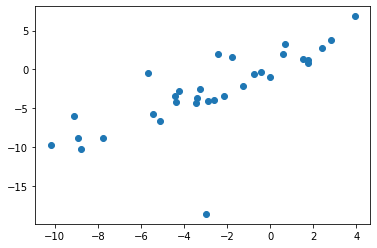

In [143]:
plt.plot(gt_imprvmt["Double Supp % Cycle"].values,pred_imprvmt["Double Supp % Cycle"].values, 'o')